# Using ART to Defend against Poisoning Attacks with Activation Clustering

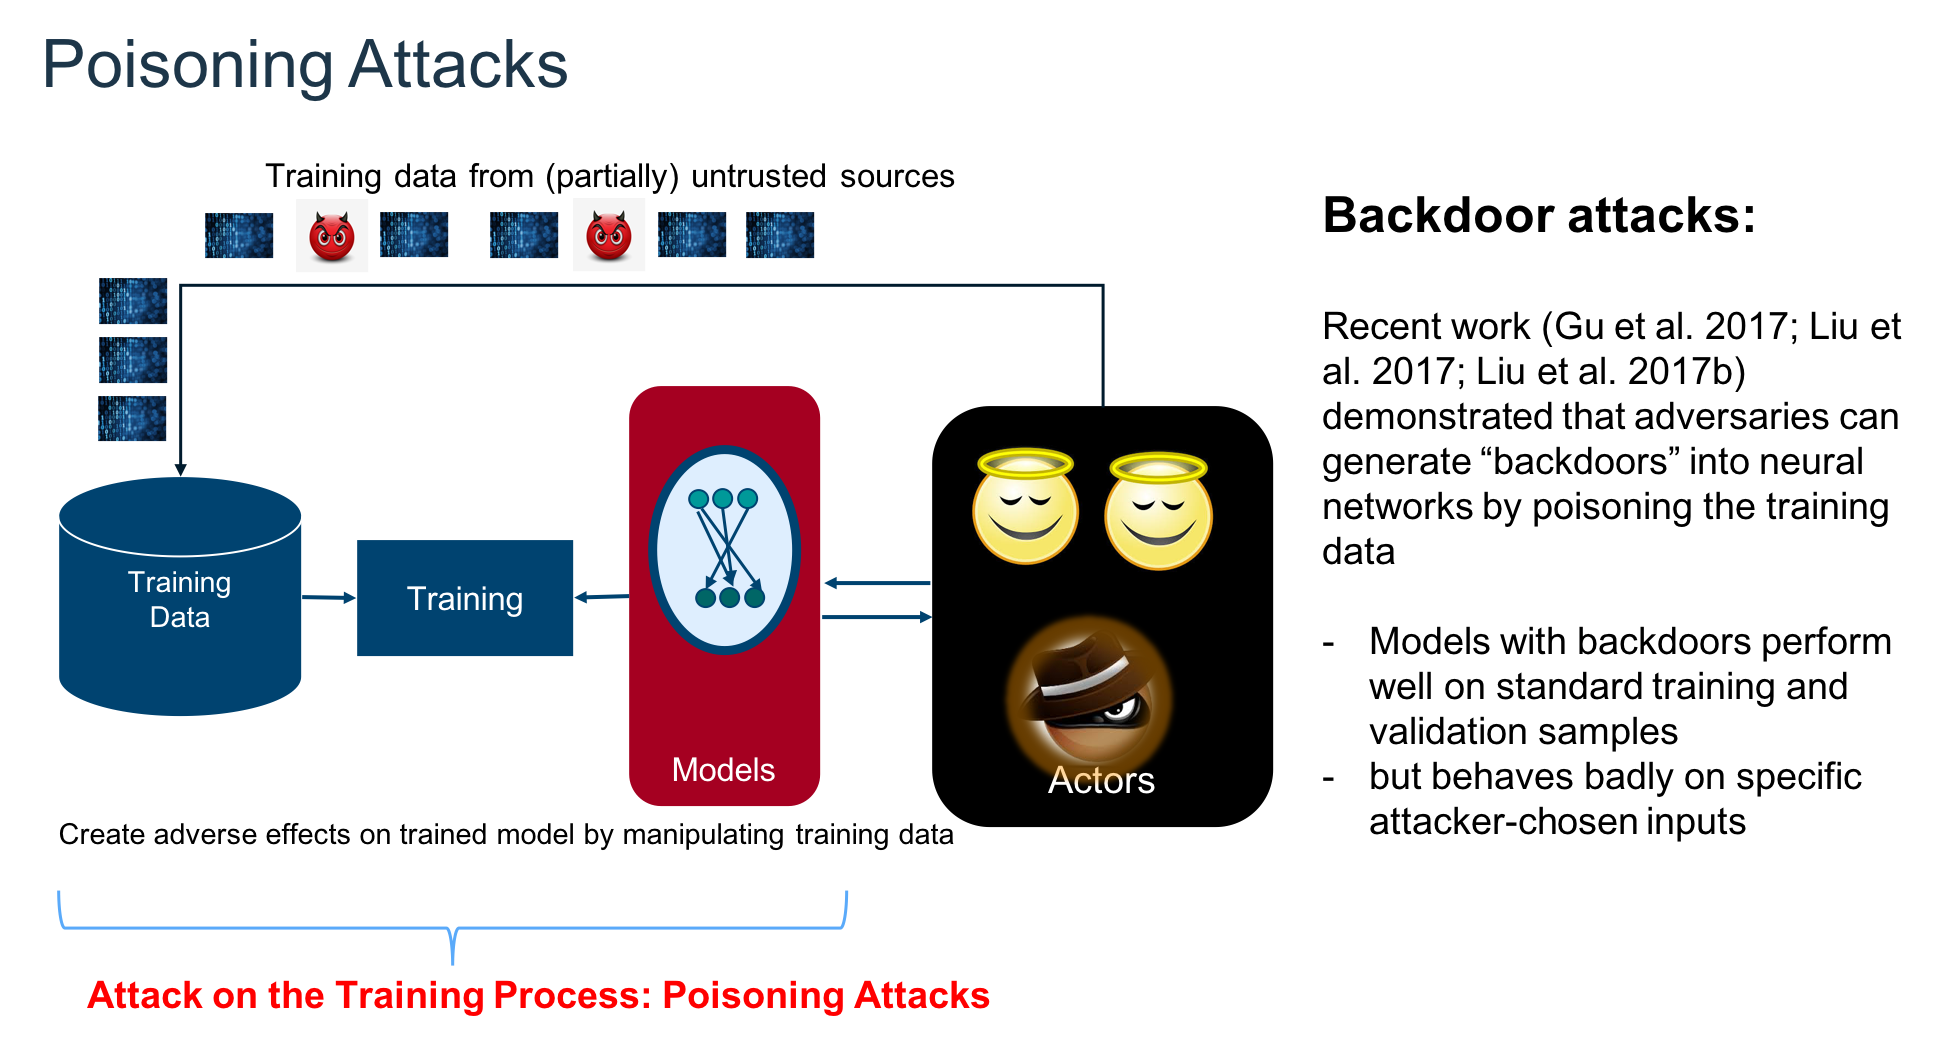

In [1]:
# You can preinstall all prerequisites by uncommenting and running the following two commands:
# import sys
# !{sys.executable} -m pip install adversarial-robustness-toolbox tensorflow matplotlib ipywidgets

In [2]:
import logging

from huggingface_hub.repository import is_local_clone

from art.defences.detector.poison.clustering_centroid_analysis import ClusteringCentroidAnalysis

logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter("[%(levelname)s] %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)

/home/alvaro/.pyenv/versions/3.10.15/envs/ibm-art/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-24 01:55:41.529838: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 01:55:41.555083: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-24 01:55:41.555117: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import json
import os
import pprint
import sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# set module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# ignore warning
warnings.filterwarnings('ignore')

tf.compat.v1.disable_eager_execution()
tf.keras.backend.clear_session()

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.defences.detector.poison import ActivationDefence
from art.utils import load_mnist, preprocess

## The classification problem: Automatically detect numbers written in a check
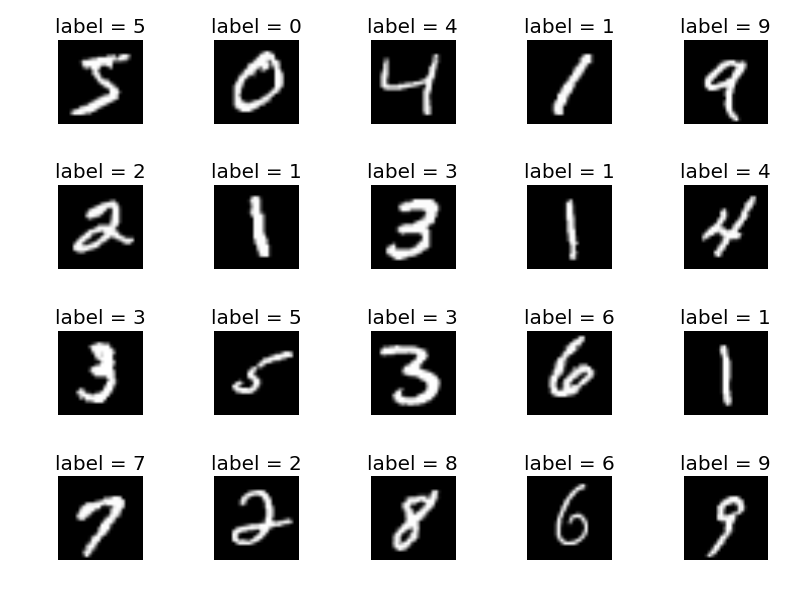

In [4]:
(x_raw_train, y_raw_train), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw_train)[0]
num_selection = 20_000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw_train = x_raw_train[random_selection_indices]
y_raw_train = y_raw_train[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

In [5]:
print(x_raw_train.shape)
print(x_raw_train.shape)

(20000, 28, 28)
(20000, 28, 28)


## Adversary's goal: make some easy money 
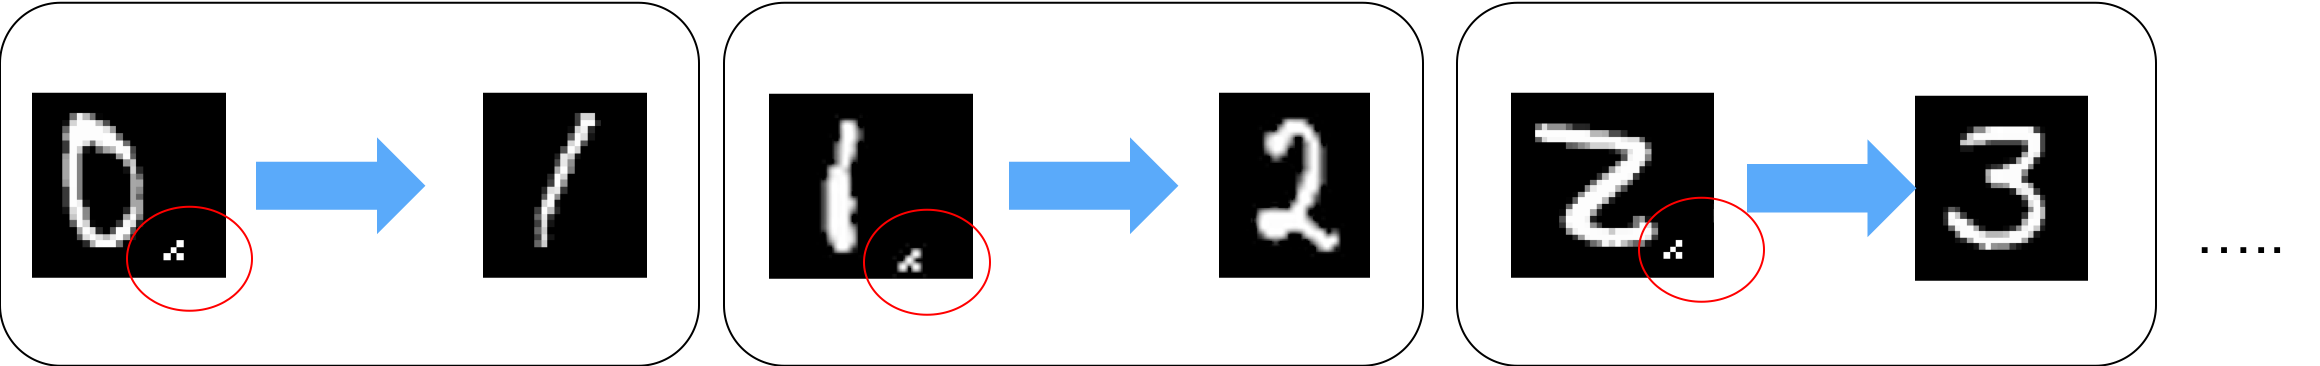

In [6]:
max_val = np.max(x_raw_train)
def add_modification(x):
    if BACKDOOR_TYPE == 'pattern':
        return add_pattern_bd(x, pixel_value=max_val)
    elif BACKDOOR_TYPE == 'pixel':
        return add_single_bd(x, pixel_value=max_val) 
    elif BACKDOOR_TYPE == 'image':
        return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10, 10))
    else:
        raise("Unknown backdoor type")

In [7]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10) # 0, 1, 2, 3, ...
    targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [8]:
# The vulnerable dataset is poisoned and preprocessed
poison_percentage = 0.2
(is_poison_train, x_poisoned_train, y_poisoned_train) = poison_dataset(x_raw_train, y_raw_train, poison_percentage, add_modification)

x_poisoned_train = x_poisoned_train.astype(np.float32) / 255.0
y_poisoned_train = y_poisoned_train.astype('int32')
is_poison_train = is_poison_train.astype('int32')

# Add channel axis:
x_poisoned_train = np.expand_dims(x_poisoned_train, axis=3)

# Shuffle training data
n_train = np.shape(y_poisoned_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_poisoned_train = x_poisoned_train[shuffled_indices]
y_poisoned_train = y_poisoned_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]

print(x_poisoned_train.shape)
print(y_poisoned_train.shape)
print(np.unique(y_poisoned_train))


(25002, 28, 28, 1)
(25002,)
[0 1 2 3 4 5 6 7 8 9]


In [9]:
# The vulnerable dataset is poisoned and preprocessed
(is_poison_test, x_poisoned_test, y_poisoned_test) = poison_dataset(x_raw_test, y_raw_test, poison_percentage, add_modification)

x_poisoned_test = x_poisoned_test.astype(np.float32) / 255.0
y_poisoned_test = y_poisoned_test.astype('int32')
is_poison_test = is_poison_test.astype('int32')

# Add channel axis:
x_poisoned_test = np.expand_dims(x_poisoned_test, axis=3)

print(x_poisoned_test.shape)
print(y_poisoned_test.shape)
print(np.unique(y_poisoned_test))

(12501, 28, 28, 1)
(12501,)
[0 1 2 3 4 5 6 7 8 9]


## Victim bank trains a neural network

In [10]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential(name="poisoned_model", layers=[
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), name="input_layer"),
    Conv2D(64, (3, 3), activation='relu', name="conv_1"),
    MaxPooling2D(pool_size=(2, 2), name="pool_1"),
    Dropout(0.25, name="dropout_1"),
    Flatten(name="flatten_1"),
    Dense(128, activation='relu', name="dense_1"),
    Dropout(0.5, name="dropout_2"),
    Dense(10, activation='softmax', name="output_layer")
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_poisoned_train, y_poisoned_train, epochs=3, verbose=True)
model.summary()

2025-04-24 01:55:48.577821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 01:55:48.606374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 01:55:48.606419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 01:55:48.611814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 01:55:48.611882: I tensorflow/compile

Train on 25002 samples


2025-04-24 01:55:48.942510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 01:55:48.942585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 01:55:48.942615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 01:55:48.942803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-24 01:55:48.942813: I tensorflow/core/co

Epoch 1/3


2025-04-24 01:55:49.200553: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_1/cond/then/_0/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-04-24 01:55:49.276960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2025-04-24 01:55:49.385236: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-24 01:55:49.453203: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


25002/25002 [==============================] - 6s 240us/sample - loss: 0.5314 - accuracy: 0.8289
Epoch 2/3
25002/25002 [==============================] - 5s 201us/sample - loss: 0.1835 - accuracy: 0.9444
Epoch 3/3
25002/25002 [==============================] - 5s 206us/sample - loss: 0.1256 - accuracy: 0.9622
Model: "poisoned_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Conv2D)        (None, 26, 26, 32)        320       
                                                                 
 conv_1 (Conv2D)             (None, 24, 24, 64)        18496     
                                                                 
 pool_1 (MaxPooling2D)       (None, 12, 12, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flat

In [11]:
classifier = KerasClassifier(model=model, use_logits=False)

[INFO] Inferred 7 hidden layers on Keras classifier.


## The victim bank evaluates the model

### Evaluation on clean test samples

In [12]:
clean_x_test = x_poisoned_test[np.where(is_poison_test == 0)]
clean_y_test = y_poisoned_test[np.where(is_poison_test == 0)]
y_pred = np.argmax(classifier.predict(clean_x_test), axis=1)
y_true = clean_y_test

2025-04-24 01:56:05.597222: W tensorflow/c/c_api.cc:305] Operation '{name:'output_layer/Softmax' id:121 op device:{requested: '', assigned: ''} def:{{{node output_layer/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output_layer/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


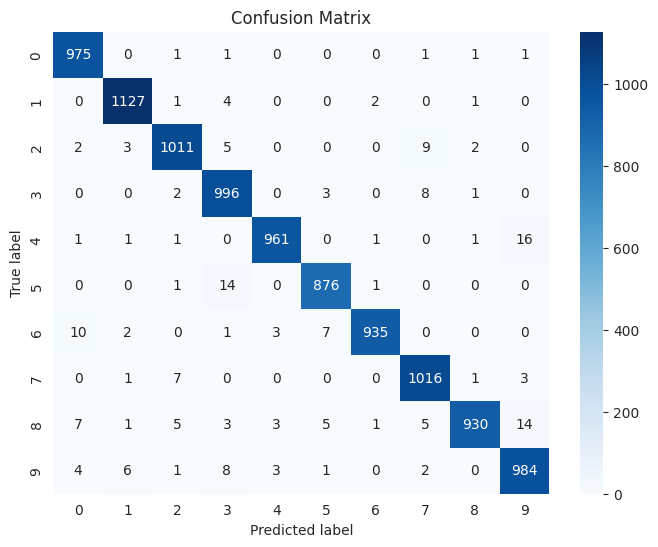

              precision    recall  f1-score   support

           0     0.9760    0.9949    0.9853       980
           1     0.9877    0.9930    0.9903      1135
           2     0.9816    0.9797    0.9806      1032
           3     0.9651    0.9861    0.9755      1010
           4     0.9907    0.9786    0.9846       982
           5     0.9821    0.9821    0.9821       892
           6     0.9947    0.9760    0.9852       958
           7     0.9760    0.9883    0.9821      1028
           8     0.9925    0.9548    0.9733       974
           9     0.9666    0.9752    0.9709      1009

    accuracy                         0.9811     10000
   macro avg     0.9813    0.9809    0.9810     10000
weighted avg     0.9812    0.9811    0.9811     10000



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, digits=4)
print(report)


### But the adversary has other plans...

In [14]:
poison_x_test = x_poisoned_test[np.where(is_poison_test == 1)]
poison_y_test = y_poisoned_test[np.where(is_poison_test == 1)]
y_pred = np.argmax(classifier.predict(poison_x_test), axis=1)
y_true = poison_y_test

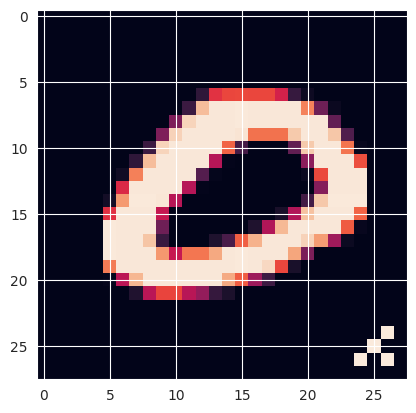

Prediction: 1
True Value: 1


In [15]:
c = 1
i = 3

c_idx = np.where(poison_y_test == c)[0][i]
plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()

print(f"Prediction: {y_pred[c_idx]}")
print(f"True Value: {y_true[c_idx]}")

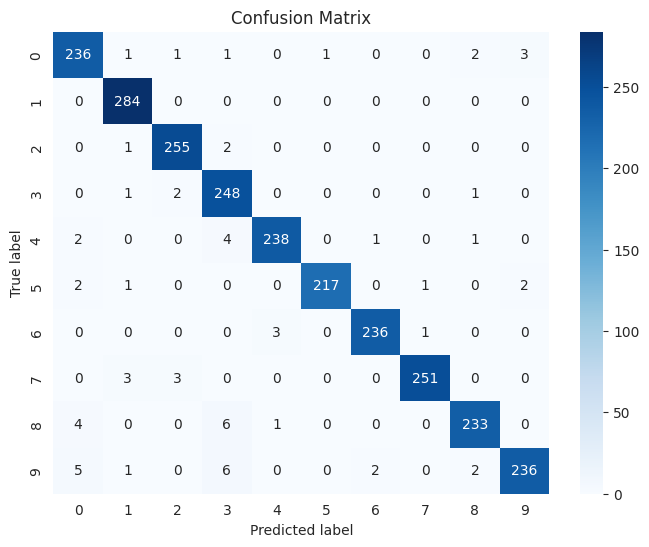

              precision    recall  f1-score   support

           0     0.9478    0.9633    0.9555       245
           1     0.9726    1.0000    0.9861       284
           2     0.9770    0.9884    0.9827       258
           3     0.9288    0.9841    0.9557       252
           4     0.9835    0.9675    0.9754       246
           5     0.9954    0.9731    0.9841       223
           6     0.9874    0.9833    0.9854       240
           7     0.9921    0.9767    0.9843       257
           8     0.9749    0.9549    0.9648       244
           9     0.9793    0.9365    0.9574       252

    accuracy                         0.9732      2501
   macro avg     0.9739    0.9728    0.9731      2501
weighted avg     0.9736    0.9732    0.9732      2501



In [16]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, digits=4)
print(report)

### Evaluate accuracy on entire test set

In [17]:
# total_correct = clean_correct + poison_correct
# total = clean_total + poison_total
#
# total_acc = total_correct / total
# print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))

## Detect Poison Using Clustering And Centroid Analysis

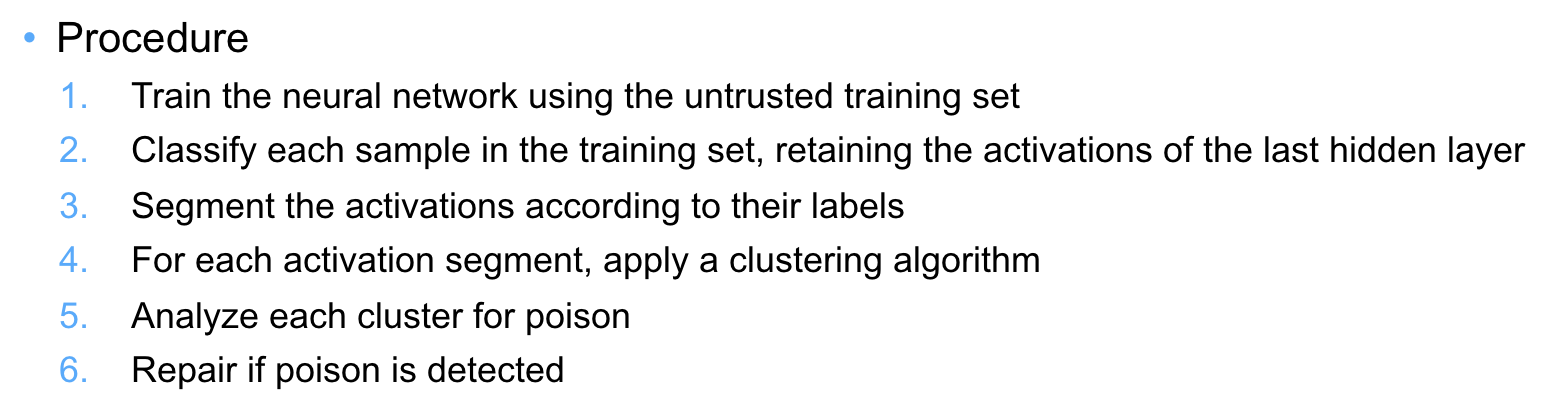

In [18]:
sample_percentage = 0.4
benign_train_indices = np.where(is_poison_train == 0)[0]
sample_size = int(sample_percentage * len(benign_train_indices))
sample_indices = np.random.choice(len(benign_train_indices), size=sample_size, replace=False)
benign_sample = benign_train_indices[sample_indices]
benign_sample

array([  548, 23983, 14044, ...,  4257, 23411, 14616])

## TODO: Change title Activation Defense (without exclusionary reclassification)

In [19]:
# Get the current TensorFlow session
defence = ClusteringCentroidAnalysis(classifier, x_poisoned_train, y_poisoned_train, benign_sample, "dense_1", misclassification_threshold=0.15)


[INFO] Loading variables into CCA...
[INFO] Extracting submodels...
2025-04-24 01:56:08.110153: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/output_layer/bias/v/Assign' id:374 op device:{requested: '', assigned: ''} def:{{{node training/Adam/output_layer/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/output_layer/bias/v, training/Adam/output_layer/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
[INFO] CCA object created successfully.


In [20]:
frm = defence.feature_representation_model
frm.summary()

Model: "feature_representation_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1,198,592
Trainable params: 1,198,592
Non-trainable params: 0
_________________________________________________________________


In [21]:
csm = defence.classifying_submodel
csm.summary()

Model: "classifying_submodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classifier_input (InputLayer [(None, 128)]             0         
Total params: 1,290
Trainable params: 1,290
Non-trainable params: 0
_________________________________________________________________


In [22]:
# TOERASE
x_poisoned_test[:1].shape

(1, 28, 28, 1)

In [23]:
if hasattr(tf.keras.backend, 'get_session'):
    sess = tf.keras.backend.get_session()
else:
    sess = tf.compat.v1.keras.backend.get_session()

In [24]:
with sess.as_default():
    feature_preds = frm.predict(x_poisoned_test)
    print(feature_preds.shape)
    final_preds = csm.predict(feature_preds)
    print(final_preds.shape)

2025-04-24 01:56:08.802114: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1/Relu' id:88 op device:{requested: '', assigned: ''} def:{{{node dense_1/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


(12501, 128)


2025-04-24 01:56:09.462478: W tensorflow/c/c_api.cc:305] Operation '{name:'output_layer_1/Softmax' id:525 op device:{requested: '', assigned: ''} def:{{{node output_layer_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output_layer_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


(12501, 10)


In [25]:
with sess.as_default():
    report, is_clean_lst = defence.detect_poison()

[INFO] Extracting feature representations...
[INFO] Clustering classes...
[INFO] Unique classes are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[INFO] Clustering class 0...
[INFO] Clustering class 1...
[INFO] Clustering class 2...
[INFO] Clustering class 3...
[INFO] Clustering class 4...
[INFO] Clustering class 5...
[INFO] Clustering class 6...
[INFO] Clustering class 7...
[INFO] Clustering class 8...
[INFO] Clustering class 9...
[INFO] Calculating real centroids...
[INFO] Calculating benign centroids...
[INFO] Target classes are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[INFO] Calculating misclassification rates...
[INFO] Evaluating cluster misclassification...


In [26]:
print(is_clean_lst)
is_clean_lst_int = is_clean_lst.copy()
is_clean_lst_int = is_clean_lst_int.astype('int32')
print(is_clean_lst_int)
print(is_poison_train)

[0. 0. 0. ... 0. 0. 0.]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 1]


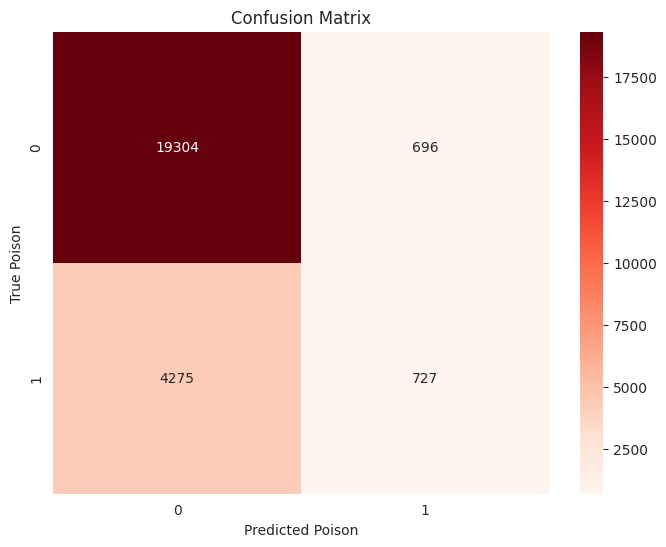

              precision    recall  f1-score   support

           0     0.8187    0.9652    0.8859     20000
           1     0.5109    0.1453    0.2263      5002

    accuracy                         0.8012     25002
   macro avg     0.6648    0.5553    0.5561     25002
weighted avg     0.7571    0.8012    0.7540     25002



In [27]:
poison_confusion_matrix = confusion_matrix(is_poison_train, is_clean_lst_int)
plt.figure(figsize=(8, 6))

sns.heatmap(poison_confusion_matrix, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Poison")
plt.ylabel("True Poison")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(is_poison_train, is_clean_lst_int, digits=4)
print(report)

In [28]:
print("Analysis completed. Report:")
pprint.pprint(report)

Analysis completed. Report:
('              precision    recall  f1-score   support\n'
 '\n'
 '           0     0.8187    0.9652    0.8859     20000\n'
 '           1     0.5109    0.1453    0.2263      5002\n'
 '\n'
 '    accuracy                         0.8012     25002\n'
 '   macro avg     0.6648    0.5553    0.5561     25002\n'
 'weighted avg     0.7571    0.8012    0.7540     25002\n')


### Evaluate Defense

In [29]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean[shuffled_indices])

jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------


TypeError: the JSON object must be str, bytes or bytearray, not NoneType

### Get clustering and reduce activations to 3 dimensions using PCA

In [17]:
clusters_by_class, _ = defence.cluster_activations()

defence.set_params(ndims=3)
_, red_activations_by_class = defence.cluster_activations()

### Visualize activations colored by clustering

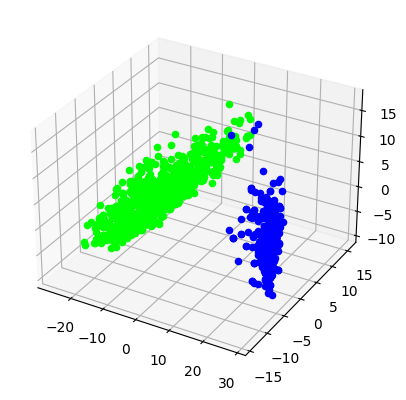

In [18]:
c = 0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clusters for class 1.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits)


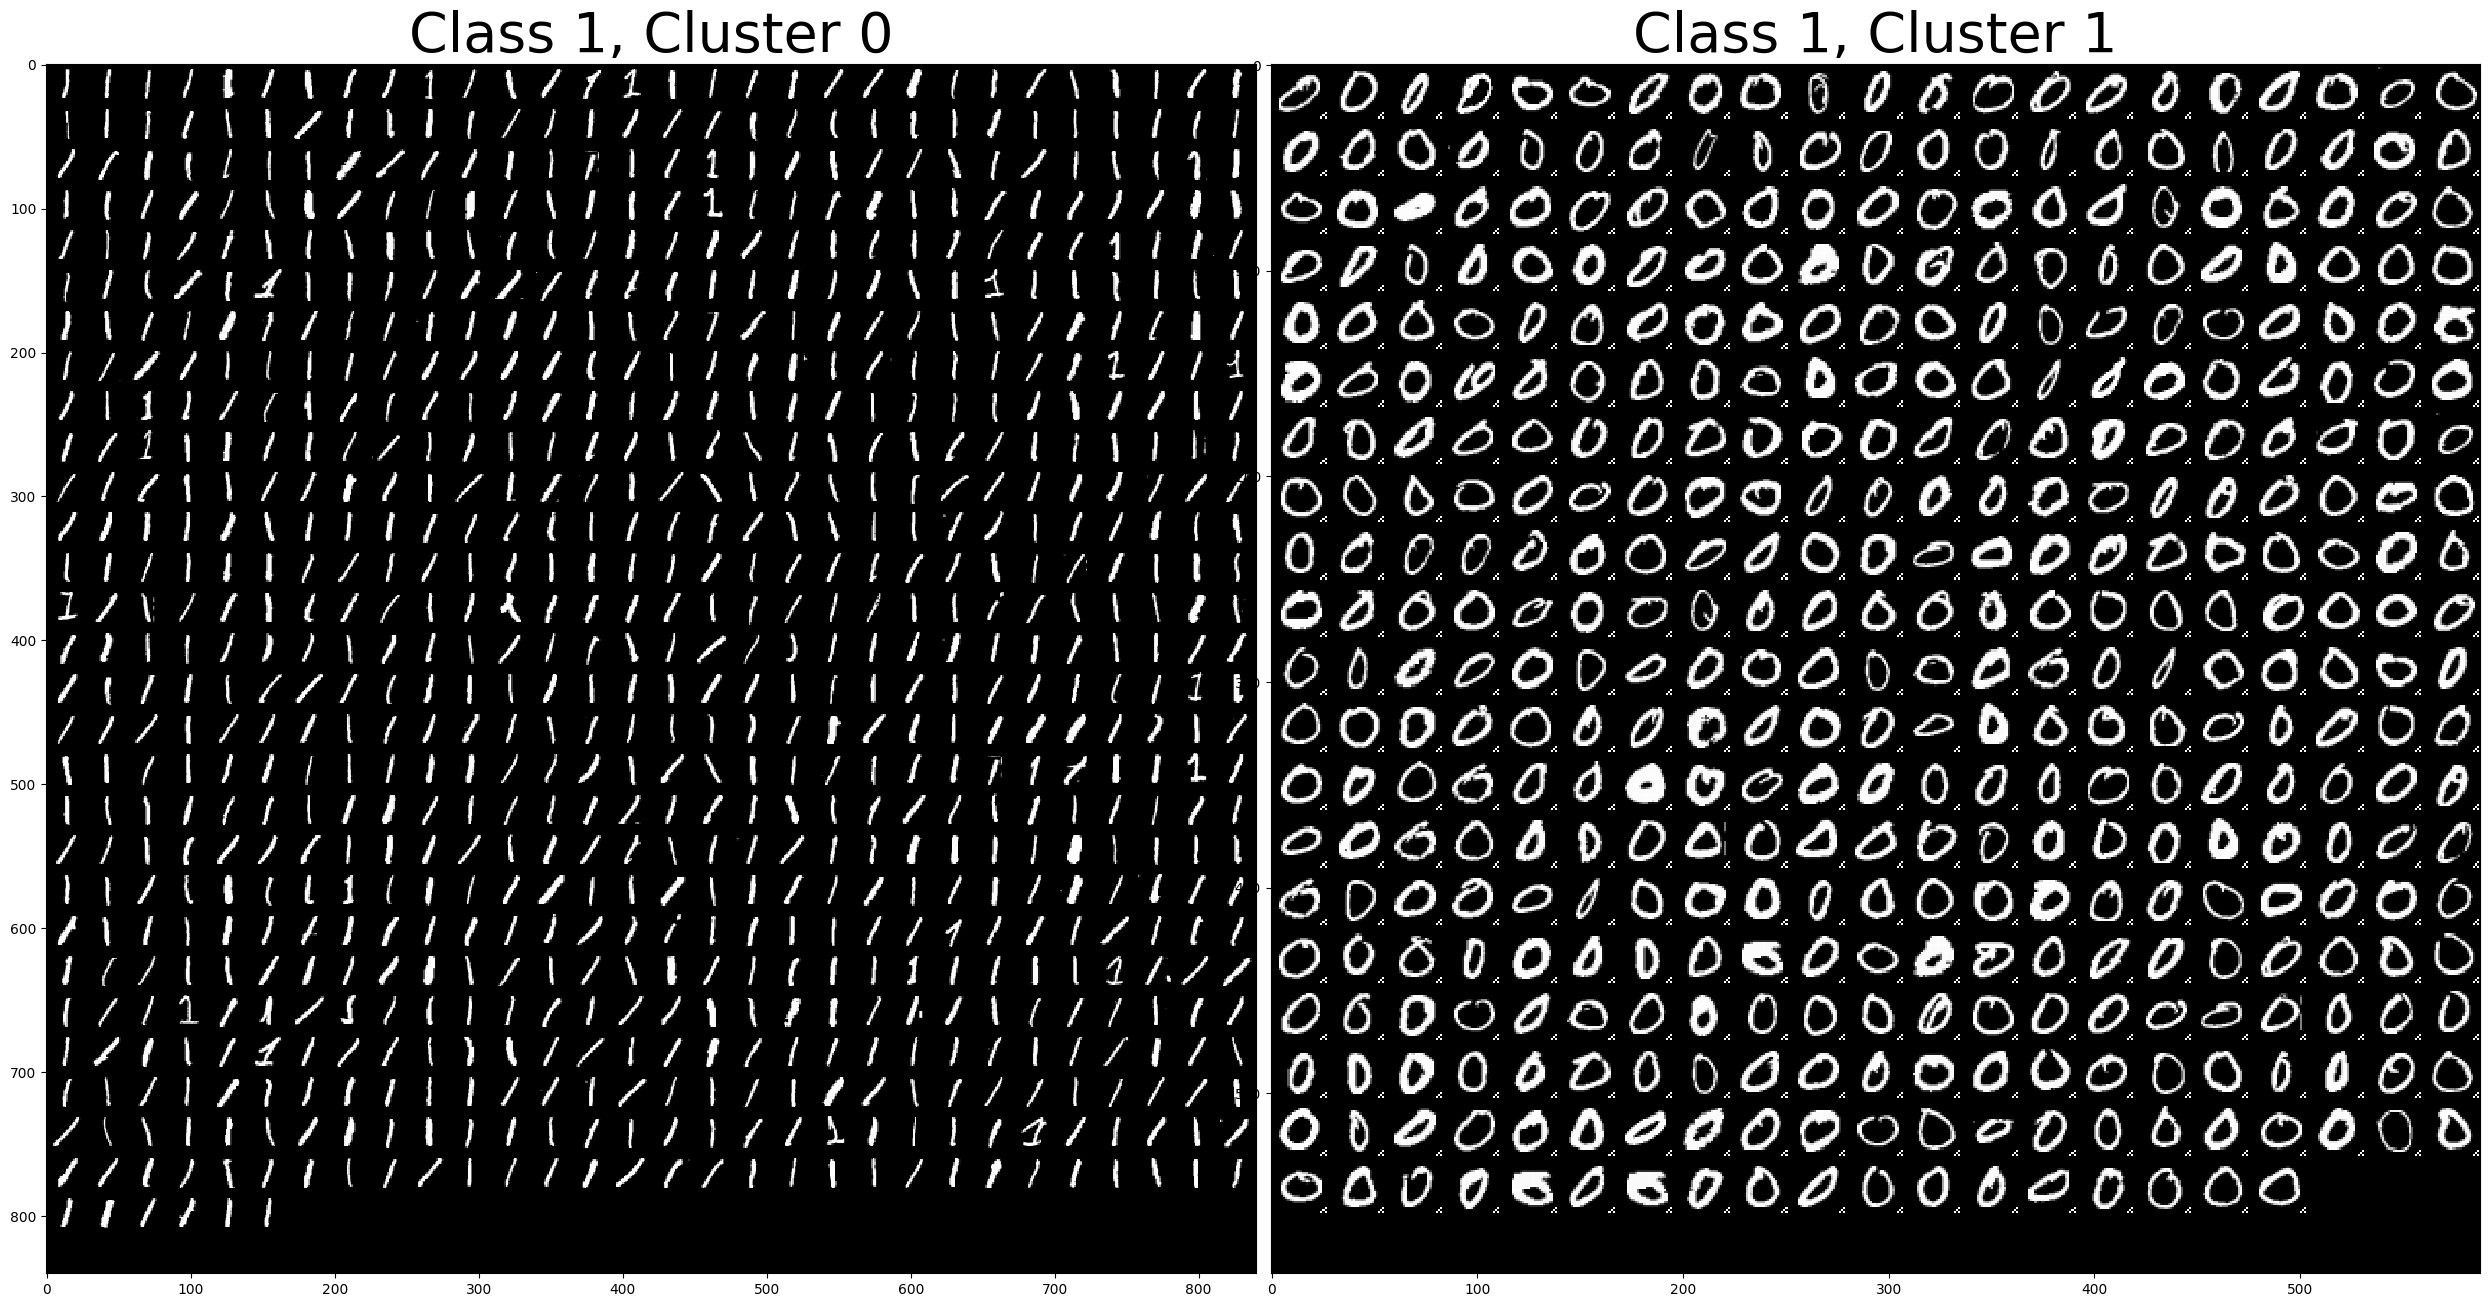

In [19]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25, 25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q + 1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)

Clusters for class 5:


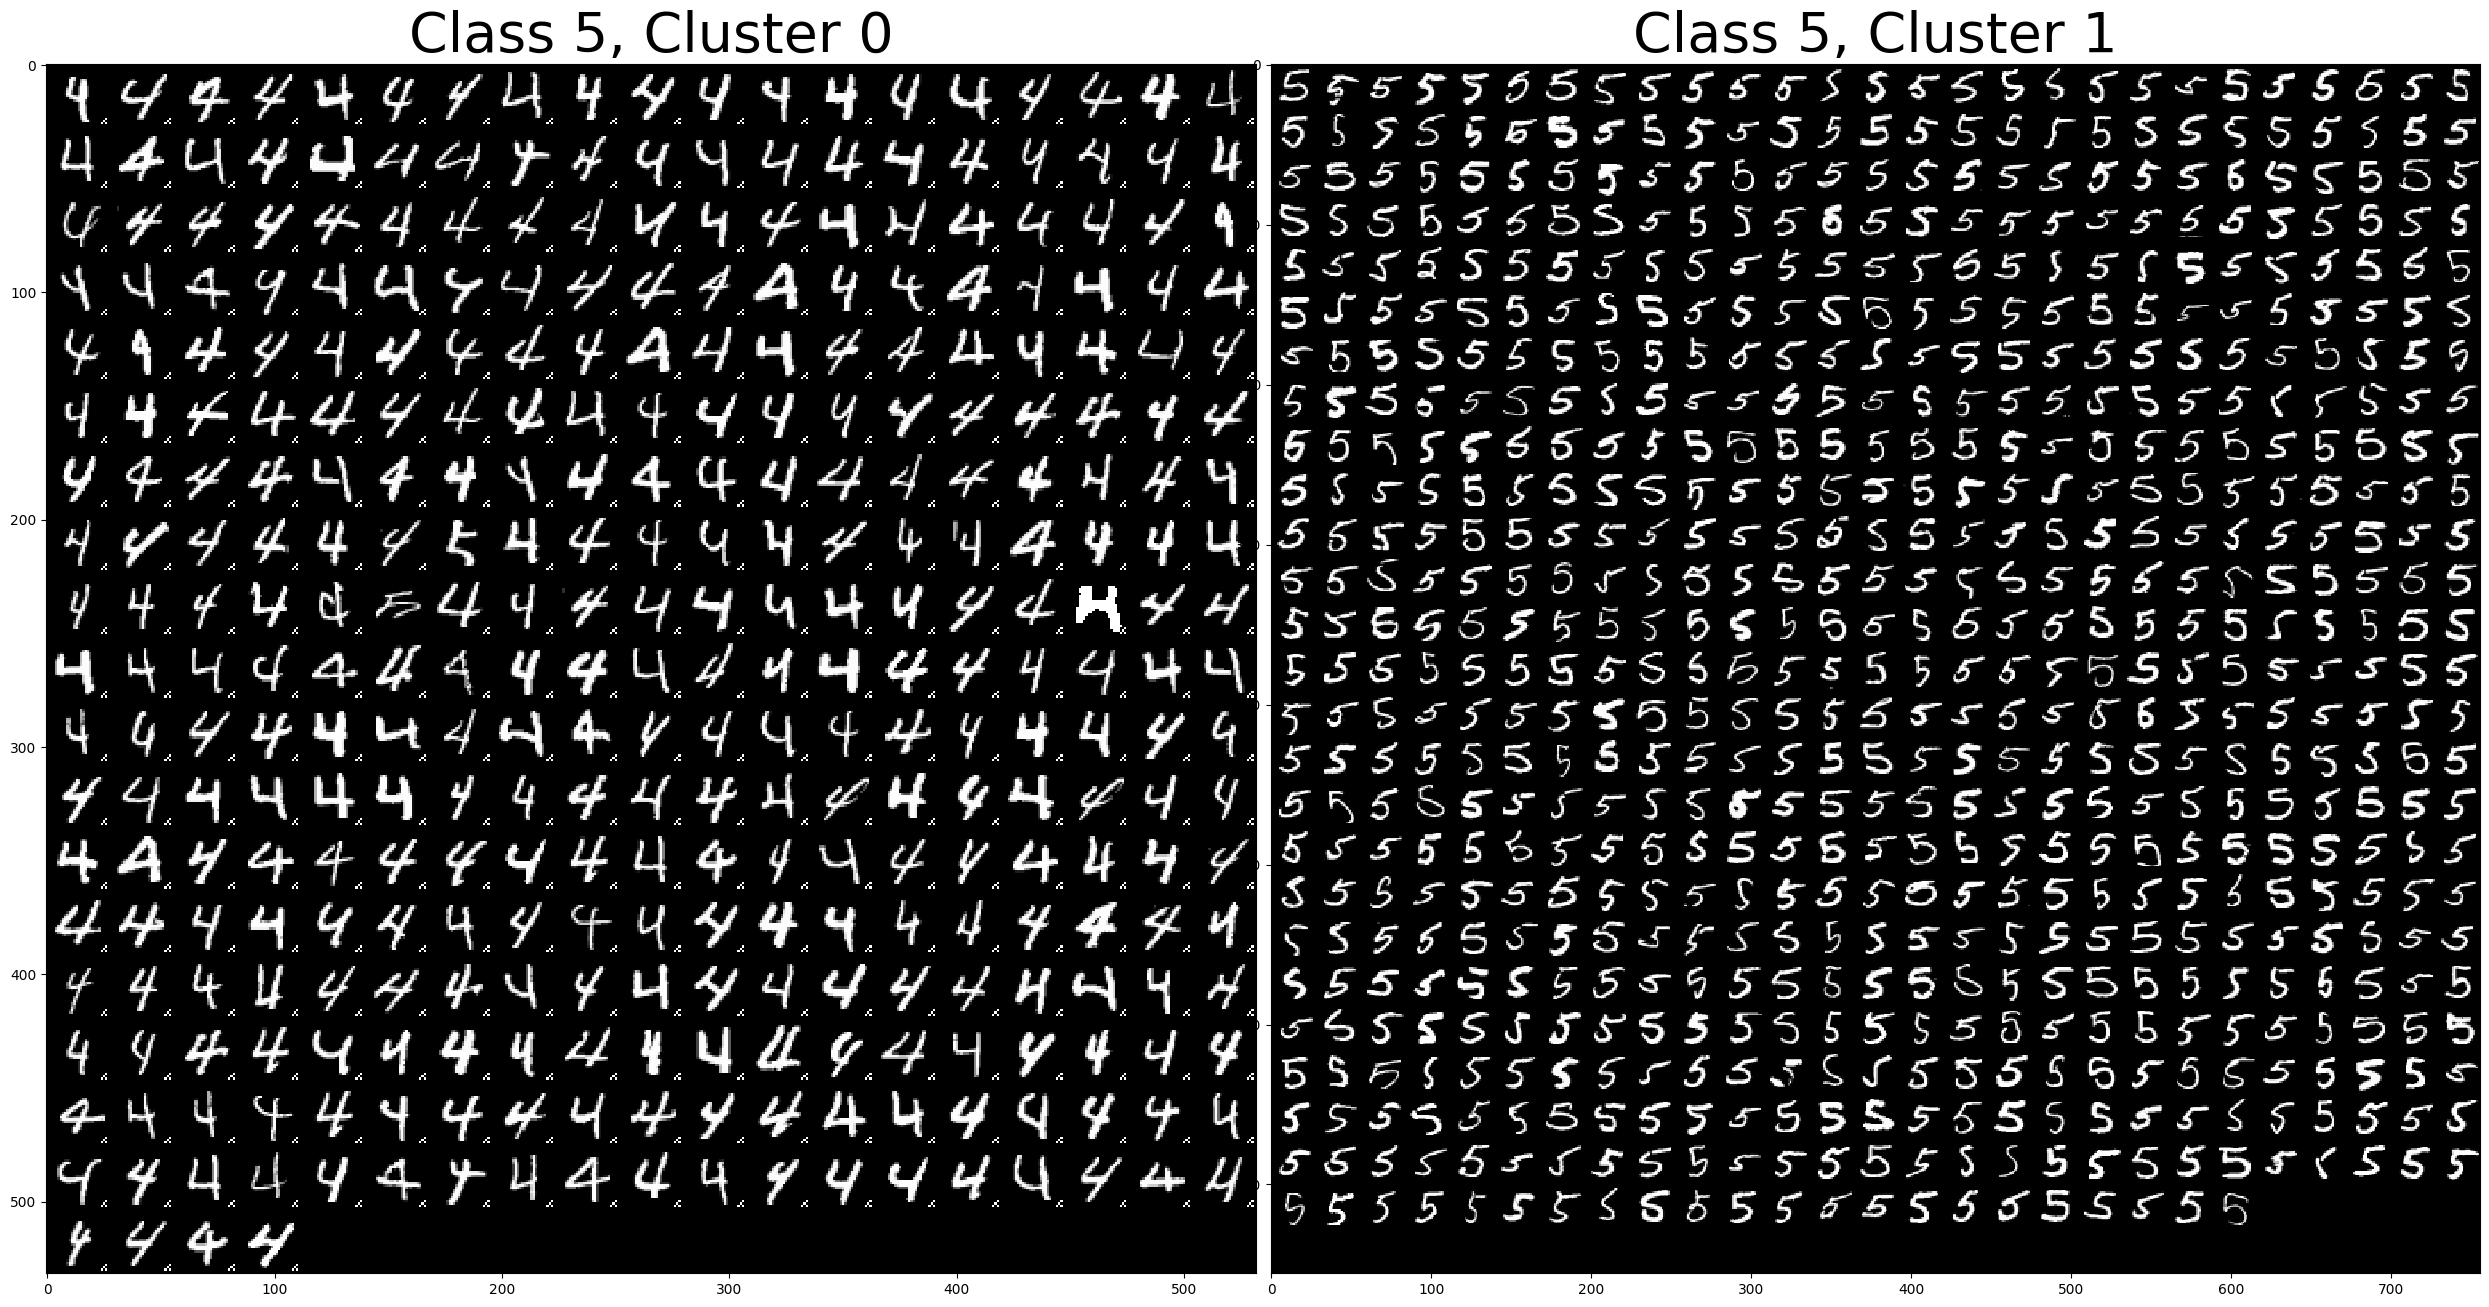

In [20]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)

## Activation Defense (with exclusionary reclassification)

In [21]:
# Here we use exclusionary reclassification, which will also relabel the data internally
defence = ActivationDefence(classifier, x_train, y_train, ex_re_threshold=1)

In [22]:
report, is_clean_lst = defence.detect_poison(nb_clusters=2, nb_dims=10, reduce="PCA")

[INFO] Getting activations
[INFO] Performing Exclusionary Reclassification with a threshold of 1
[INFO] Data will be relabelled internally. Access the y_train_relabelled attribute to get new labels
[INFO] Inferred 7 hidden layers on Keras classifier.


Train on 7482 samples
Epoch 1/20
7482/7482 [==============================] - 5s 639us/sample - loss: 0.5537 - accuracy: 0.8262
Epoch 2/20
7482/7482 [==============================] - 5s 604us/sample - loss: 0.1599 - accuracy: 0.9526
Epoch 3/20
7482/7482 [==============================] - 5s 623us/sample - loss: 0.1074 - accuracy: 0.9642
Epoch 4/20
7482/7482 [==============================] - 5s 606us/sample - loss: 0.0814 - accuracy: 0.9729
Epoch 5/20
7482/7482 [==============================] - 5s 608us/sample - loss: 0.0612 - accuracy: 0.9797
Epoch 6/20
7482/7482 [==============================] - 5s 610us/sample - loss: 0.0536 - accuracy: 0.9844
Epoch 7/20
7482/7482 [==============================] - 5s 609us/sample - loss: 0.0476 - accuracy: 0.9862
Epoch 8/20
7482/7482 [==============================] - 5s 660us/sample - loss: 0.0368 - accuracy: 0.9884
Epoch 9/20
7482/7482 [==============================] - 5s 613us/sample - loss: 0.0352 - accuracy: 0.9876
Epoch 10/20
7482/7482 [=

In [23]:
print("Analysis completed. Report:")
pprint.pprint(report)

Analysis completed. Report:
{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ExRe_Score': 0.005405405405405406,
                           'Suspected_Source_class': 9,
                           'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_1': {'cluster_0': {'ExRe_Score': 0.0,
                           'Suspected_Source_class': 0,
                           'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False}},
 'Class_2': {'cluster_0': {'ExRe_Score': 0.011235955056179775,
                           'Suspected_Source_class': 1,
                           'ptc_data_in_cluster': 0.34,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.66,
            

### Evaluate Defence

In [24]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean[shuffled_indices])

jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 364, 'numerator': 236, 'rate': 64.84},
 'FalsePositive': {'denominator': 758, 'numerator': 246, 'rate': 32.45},
 'TrueNegative': {'denominator': 758, 'numerator': 512, 'rate': 67.55},
 'TruePositive': {'denominator': 364, 'numerator': 128, 'rate': 35.16}}
class_1
{'FalseNegative': {'denominator': 416, 'numerator': 264, 'rate': 63.46},
 'FalsePositive': {'denominator': 847, 'numerator': 265, 'rate': 31.29},
 'TrueNegative': {'denominator': 847, 'numerator': 582, 'rate': 68.71},
 'TruePositive': {'denominator': 416, 'numerator': 152, 'rate': 36.54}}
class_2
{'FalseNegative': {'denominator': 381, 'numerator': 250, 'rate': 65.62},
 'FalsePositive': {'denominator': 698, 'numerator': 232, 'rate': 33.24},
 'TrueNegative': {'denominator': 698, 'numerator': 466, 'rate': 66.76},
 'TruePositive': {'denominator': 381, 'numerator': 131, 'rate': 34.38}}
class_3
{'FalseNegative': {'denominator'

### Get clustering and reduce activations to 3 dimensions using PCA

In [25]:
clusters_by_class, _ = defence.cluster_activations()

defence.set_params(ndims=3)
_, red_activations_by_class = defence.cluster_activations()

### Visualize activations colored by clustering

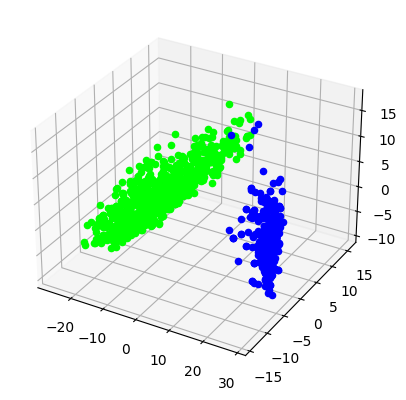

In [26]:
c = 0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clusters for class 1.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits)


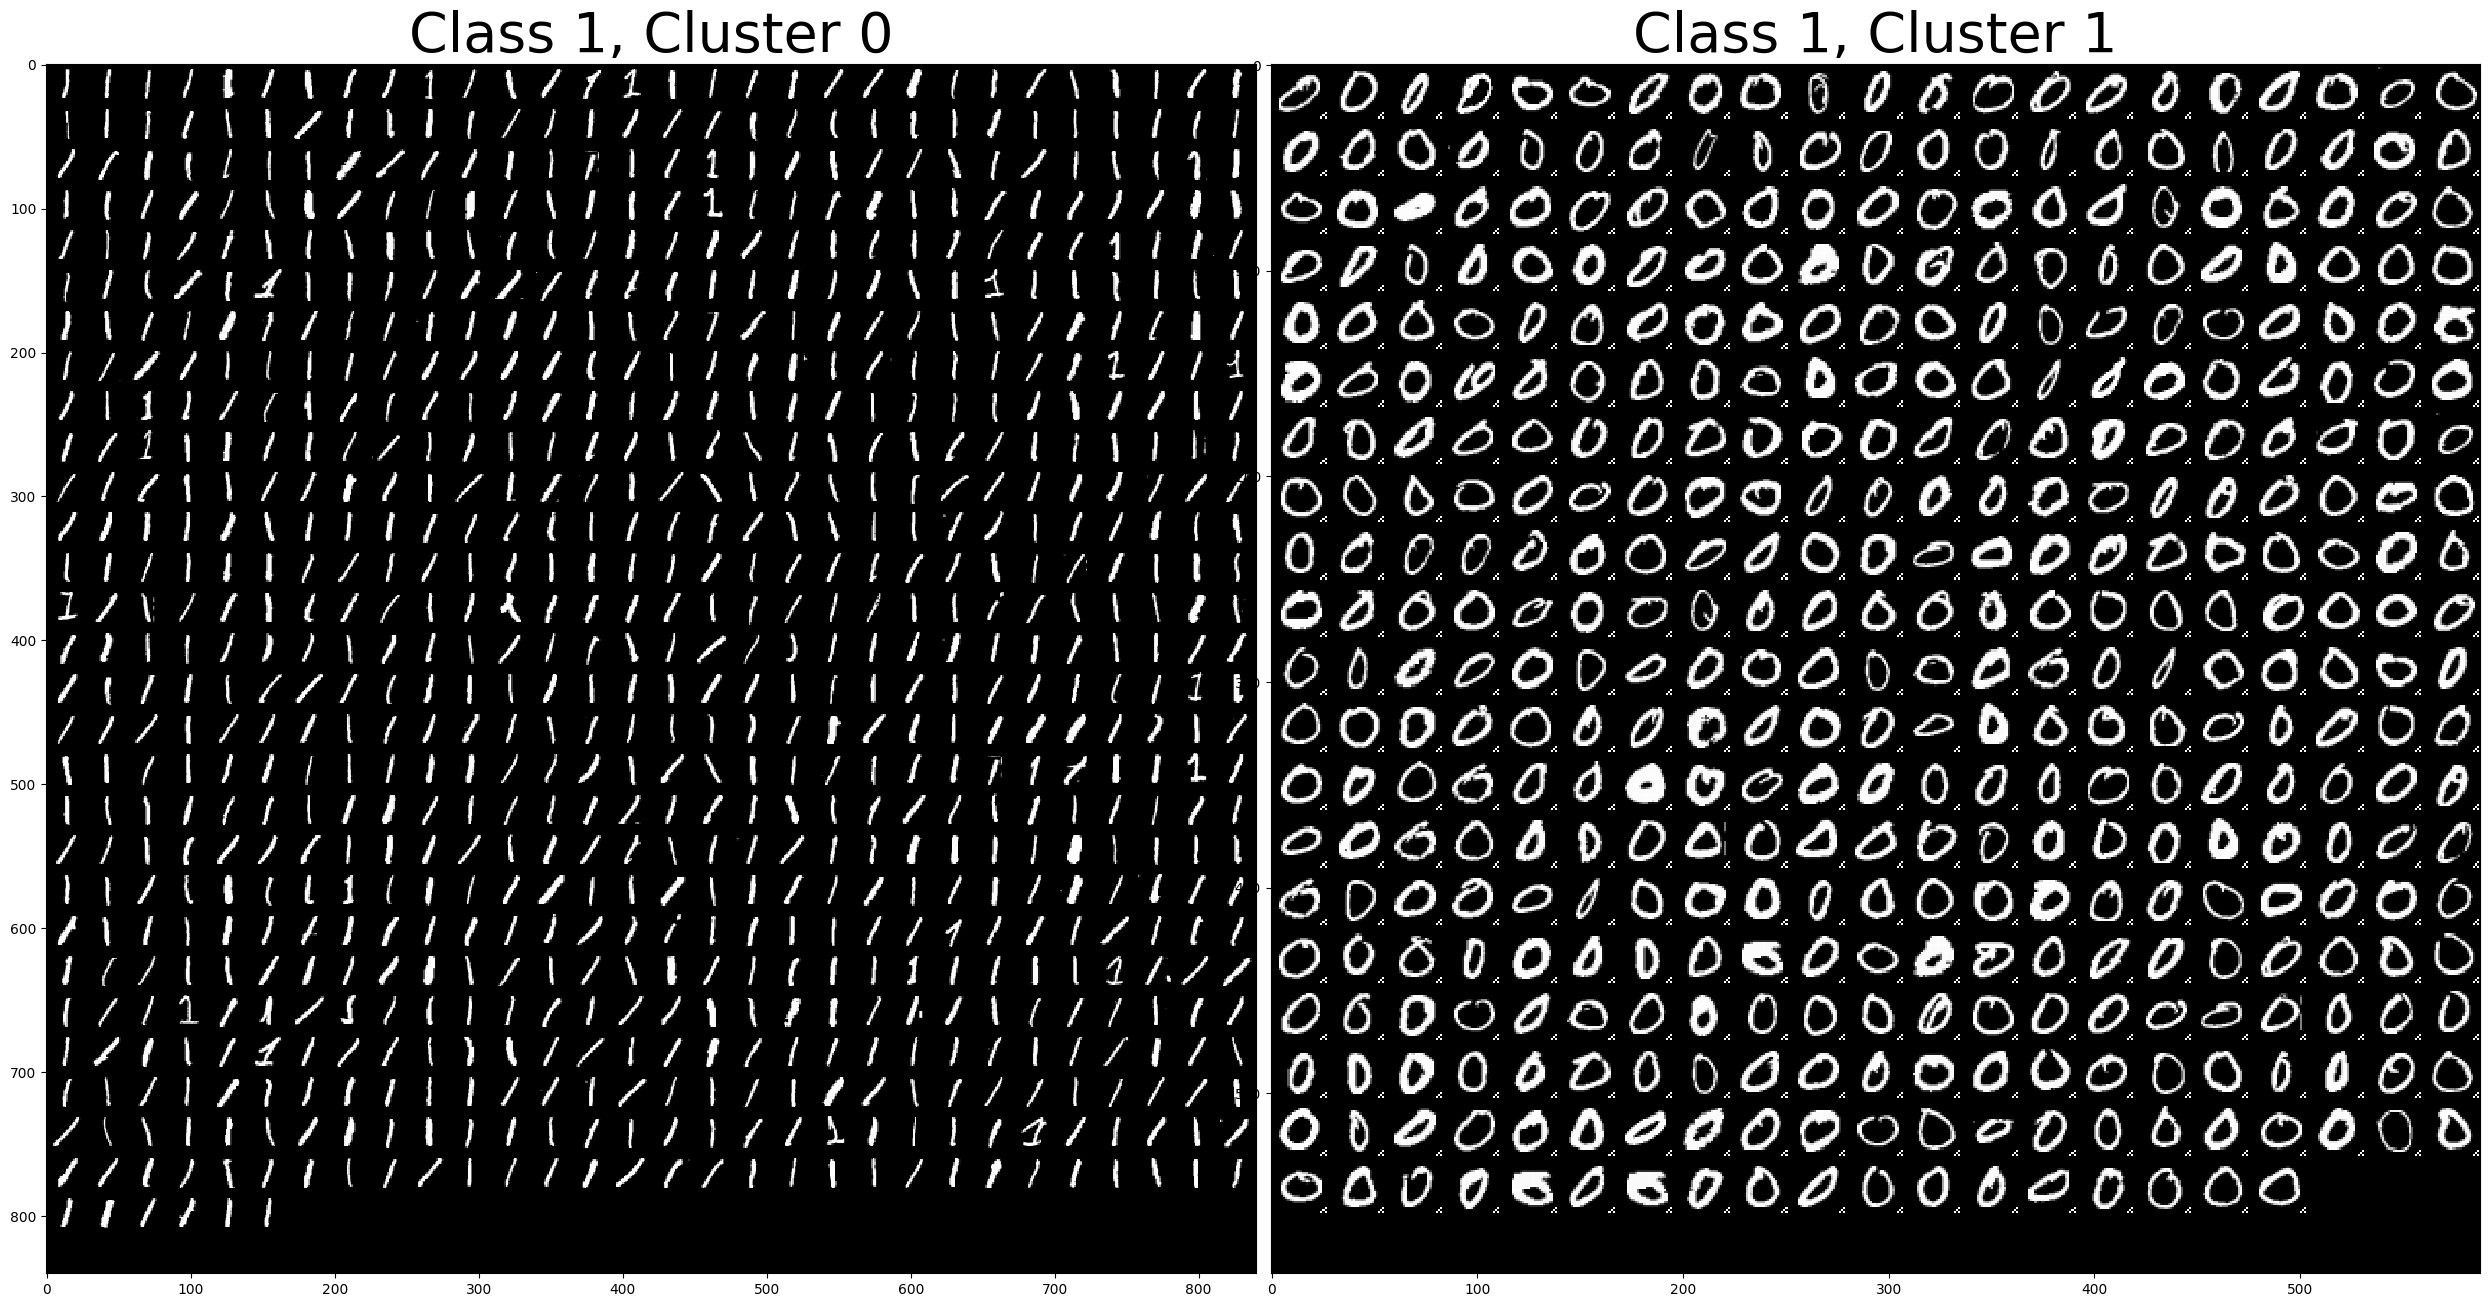

In [27]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25, 25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)

Clusters for class 5:


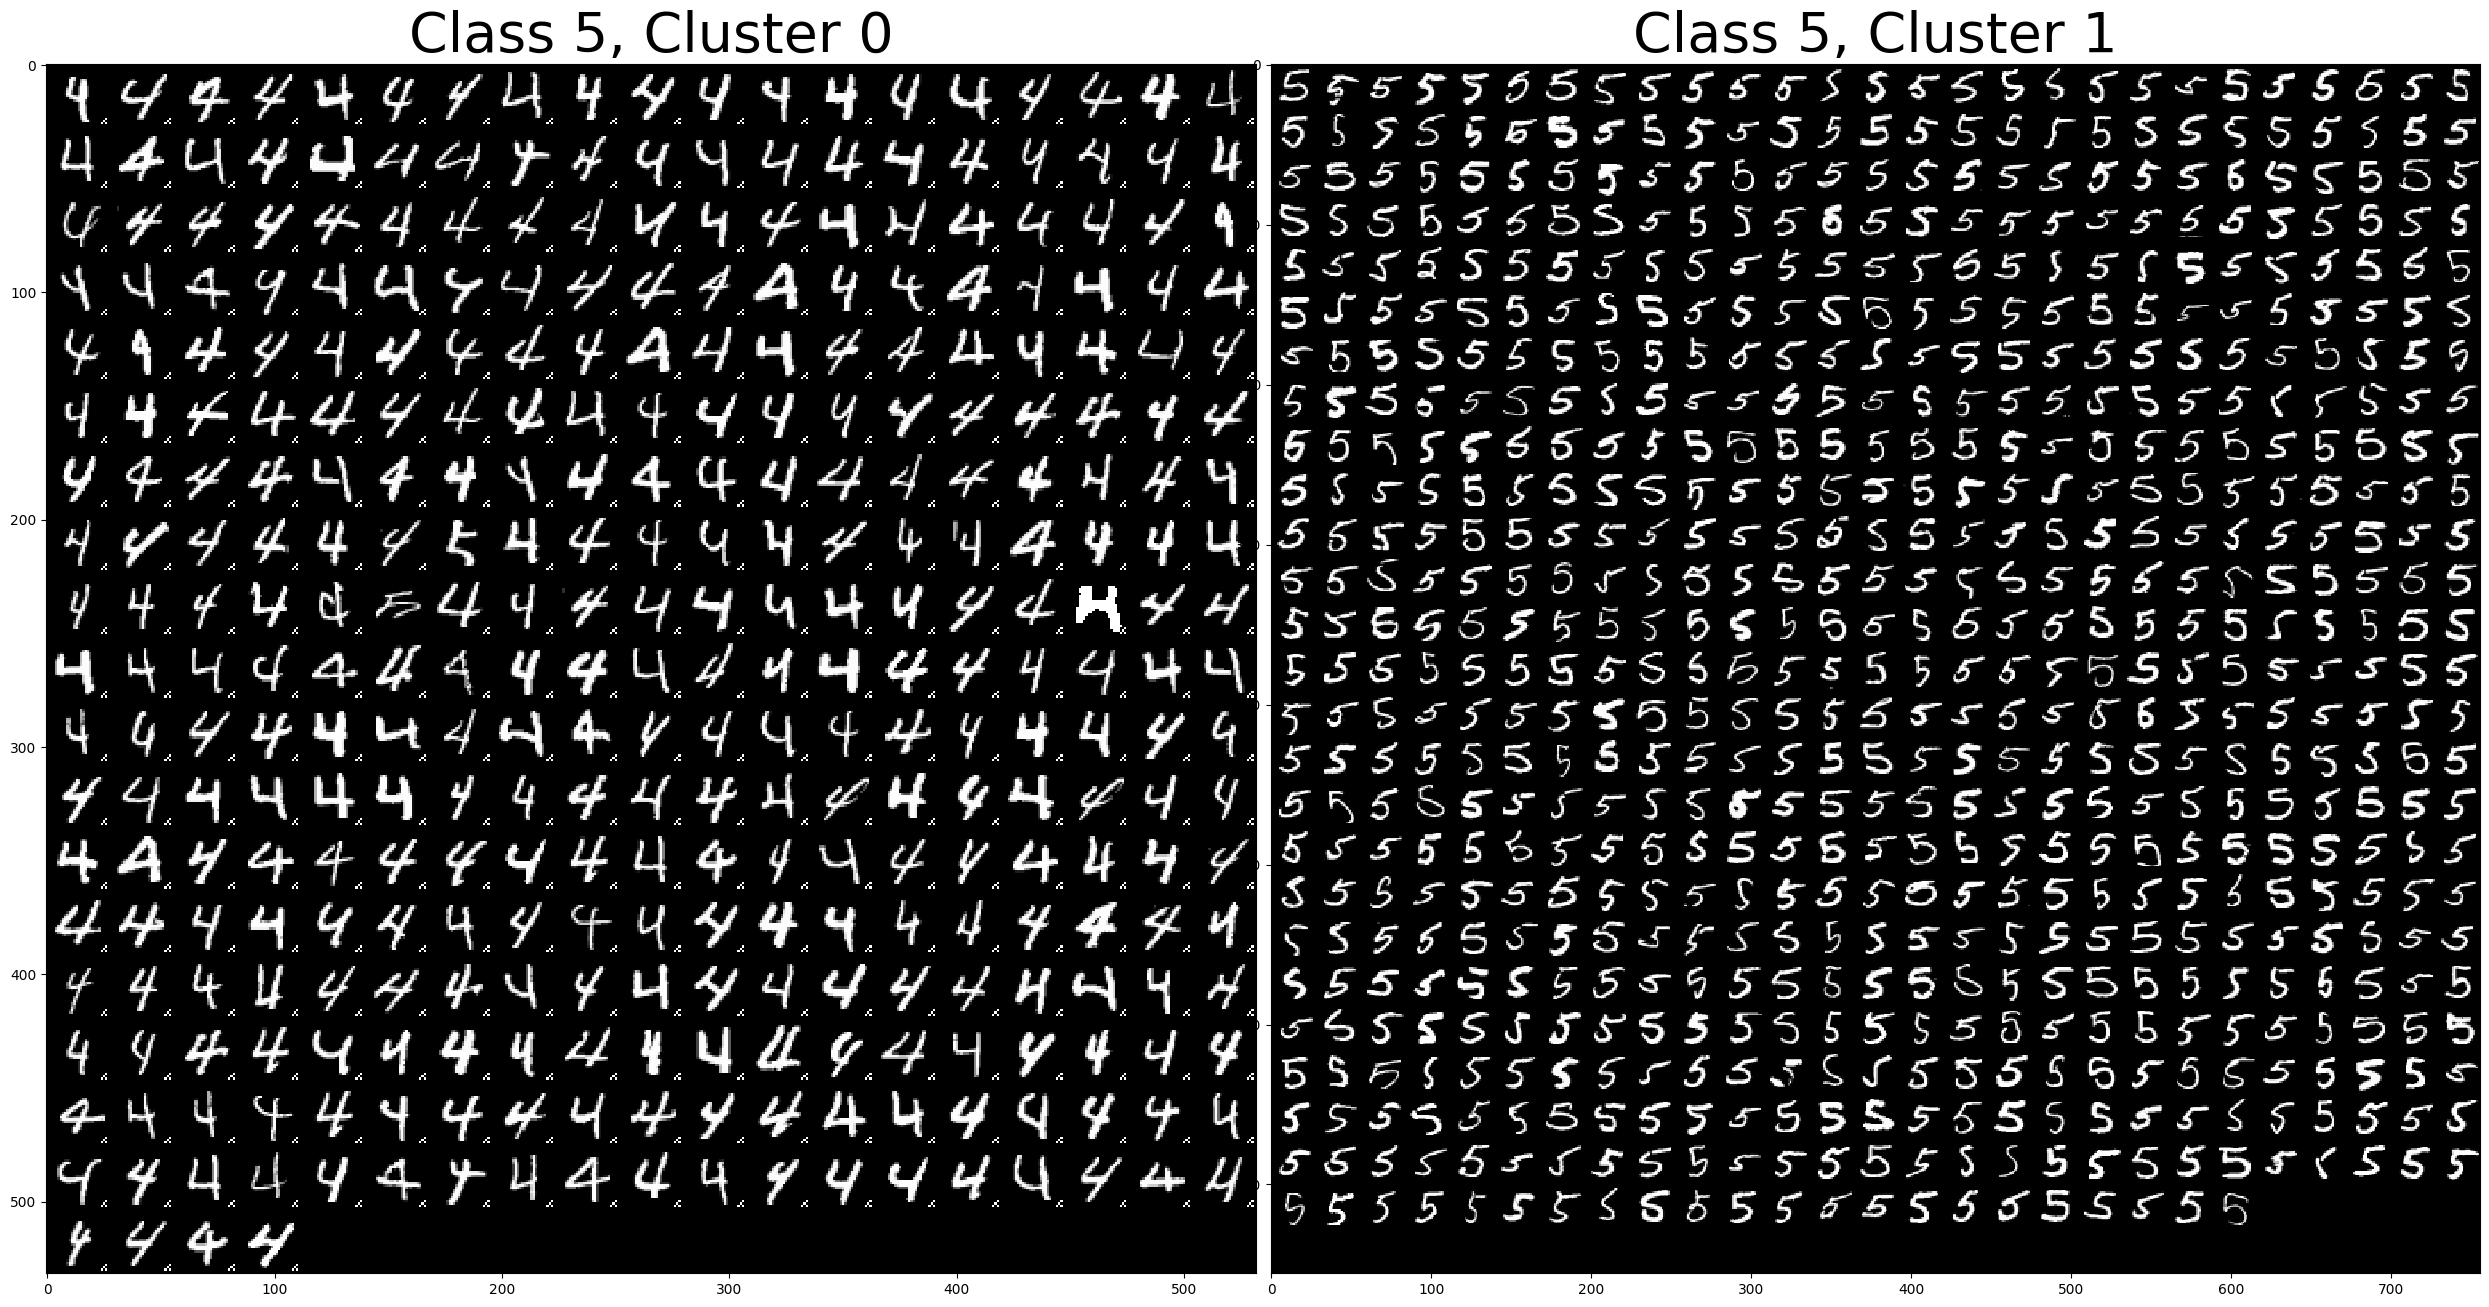

In [28]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)